In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm


# Set-up

## Load data

In [2]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Get class names
# imagenet_class_nums = np.arange(0, 1000, 1)
# imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# # Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)


# Patch/image-level analysis for maximally activating neurons

Look at maximally activating neurons with patch/image as the individual unit.

Loaded from precached activations from 500 randomly sampled ImageNet points.

In [3]:
import pandas as pd
import os

layer_num = 7

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name = f'mlp_fc1_{layer_num}.npz'

loaded = pd.read_parquet(os.path.join(save_path, file_name))


### Get standard deviation of patch value 

On the neuron level (aggregating across all images and patches for that neuron)**

In [4]:
# Calculate mean and standard deviation for 'activation_value' grouped by 'neuron_idx'
grouped = loaded.groupby('neuron_idx')['activation_value']
mean_per_neuron = grouped.transform('mean')
std_dev_per_neuron = grouped.transform('std')

# Calculate the z-score (number of standard deviations from the mean)
loaded['activation_value_sds'] = (loaded['activation_value'] - mean_per_neuron) / std_dev_per_neuron

# Replace NaN and infinite values (which can occur if std_dev is zero) with zero
loaded['activation_value_sds'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)


# Sort by z-score
sorted_df = loaded.sort_values(by=['activation_value_sds'], ascending=False)

### Visualize heatmap for specific image + neuron

In [5]:
import pandas as pd


def plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224, pixel_num=14):

    activation_values_array = activation_values_array.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

    # Plotting the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1,2,0))
    ax.imshow(heatmap, cmap='viridis', alpha=0.4)  # Overlaying the heatmap

    # Removing axes
    ax.axis('off')

    min_activation = activation_values_array.min()
    max_activation = activation_values_array.max()

    # Adding colorbar for the heatmap
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

    plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
    plt.show()




In [6]:
def get_image_and_activations_by_id(specific_neuron_idx, specific_image_idx):
    image, label = load_specific_image(imagenet_data, random_indices, specific_image_idx)

    filtered_df = loaded[(loaded['batch_idx'] == specific_image_idx) & 
                                (loaded['neuron_idx'] == specific_neuron_idx)]

    activation_values = filtered_df['activation_value_sds']

    activation_values_array = activation_values.to_numpy()[1:]

    return image, activation_values_array


# Load saved indices
random_indices = np.load('imagenet_sample_indices.npy')

# Function to load a specific image
def load_specific_image(dataset, indices, order):
    specific_index = indices[order]  # Subtract 1 because list indices start at 0
    image, label = dataset[specific_index]
    return image, label


Top 10 Unique Class Names: ['Norwegian_elkhound', 'alp', 'tub', 'ibex', 'zebra', 'stretcher', 'plow', 'hippopotamus', 'megalith', 'snowplow', 'dock', 'promontory', 'brass', 'German_short-haired_pointer', 'sandbar', 'book_jacket', "carpenter's_kit", 'packet', 'swimming_trunks', 'torch', 'ptarmigan', 'rule', 'Labrador_retriever', 'Eskimo_dog', 'beach_wagon', 'envelope', 'Irish_terrier', 'pop_bottle', 'wire-haired_fox_terrier', 'beacon']
Corresponding Activations: [2.7789981365203857, 2.194882869720459, 1.8612807989120483, 1.7690489292144775, 1.6845625638961792, 1.5807989835739136, 1.5365079641342163, 1.46246337890625, 1.392324447631836, 1.3811978101730347, 1.3437228202819824, 1.3092180490493774, 1.2548496723175049, 1.0241700410842896, 0.9851382374763489, 0.974570631980896, 0.8589165806770325, 0.8486865162849426, 0.8464438915252686, 0.8198298811912537, 0.8188760280609131, 0.8118782043457031, 0.7559043169021606, 0.7157484889030457, 0.7048681378364563, 0.6871130466461182, 0.6727038025856018

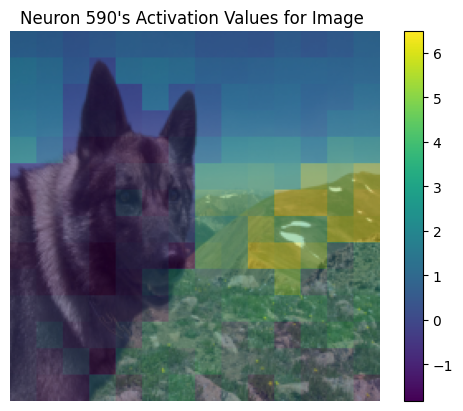

Class Name: Norwegian_elkhound
Activation Value: 2.7789981365203857
Batch Index: 182



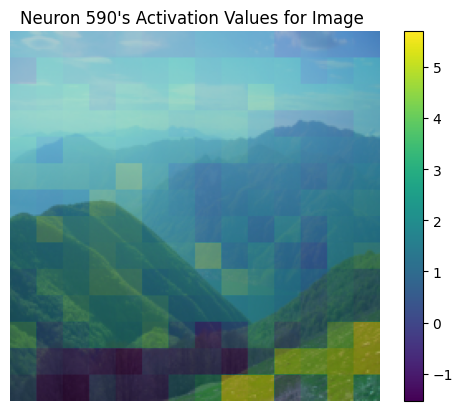

Class Name: alp
Activation Value: 2.194882869720459
Batch Index: 222



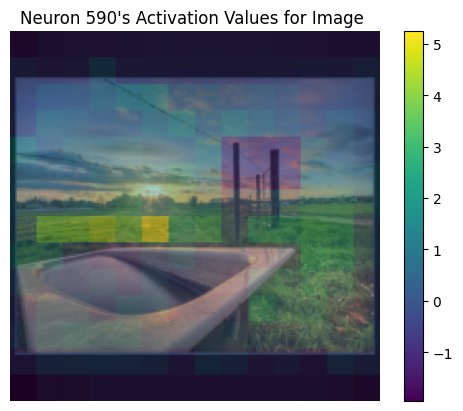

Class Name: tub
Activation Value: 1.8612807989120483
Batch Index: 58



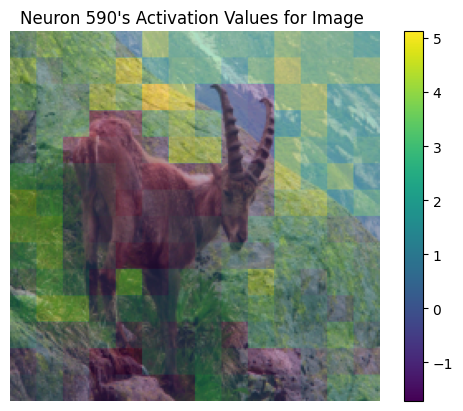

Class Name: ibex
Activation Value: 1.7690489292144775
Batch Index: 49



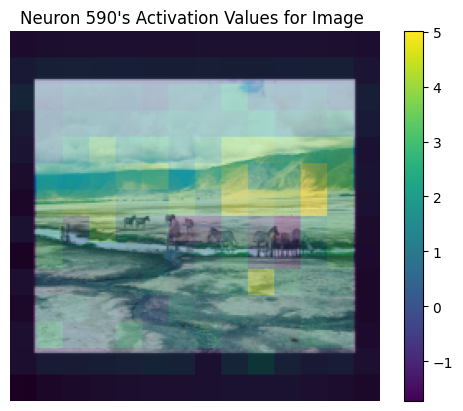

Class Name: zebra
Activation Value: 1.6845625638961792
Batch Index: 181



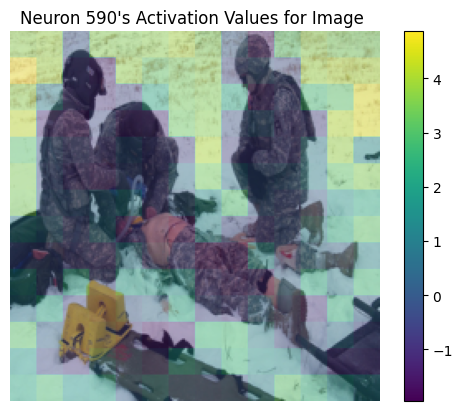

Class Name: stretcher
Activation Value: 1.5807989835739136
Batch Index: 40



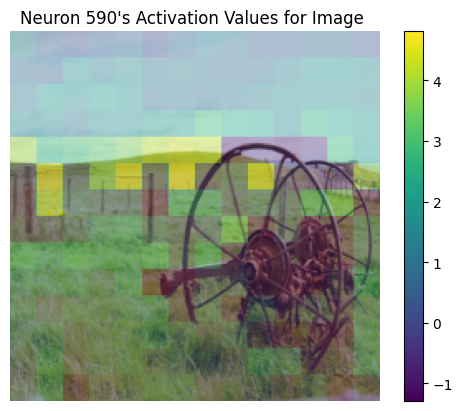

Class Name: plow
Activation Value: 1.5365079641342163
Batch Index: 103



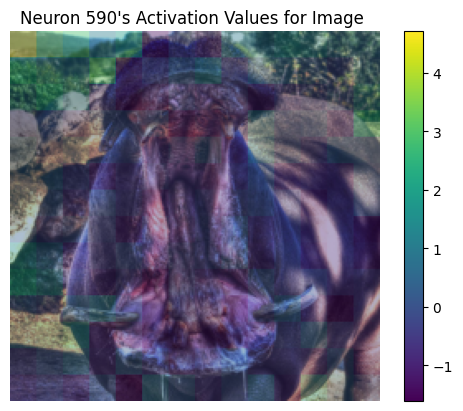

Class Name: hippopotamus
Activation Value: 1.46246337890625
Batch Index: 59



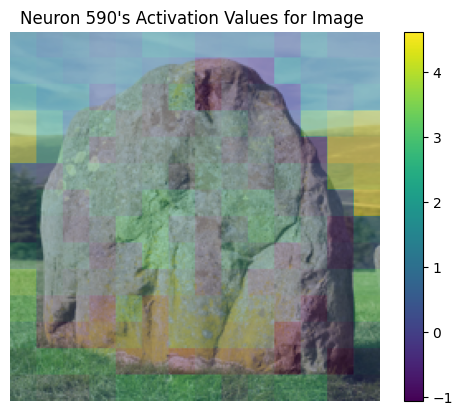

Class Name: megalith
Activation Value: 1.392324447631836
Batch Index: 257



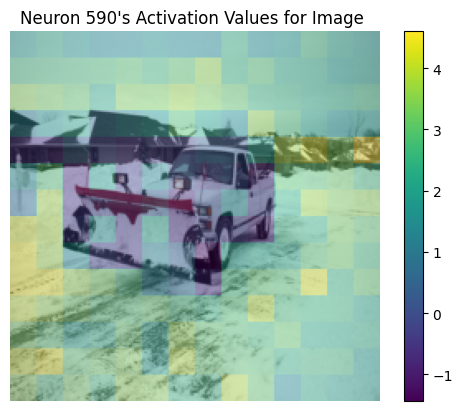

Class Name: snowplow
Activation Value: 1.3811978101730347
Batch Index: 192



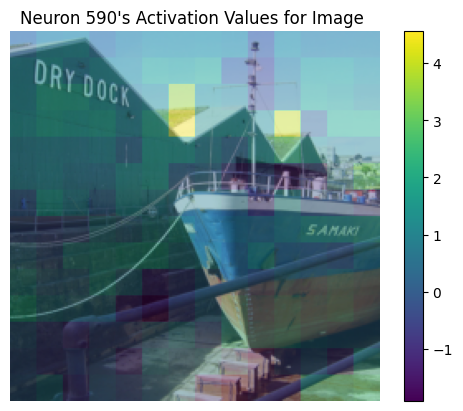

Class Name: dock
Activation Value: 1.3437228202819824
Batch Index: 372



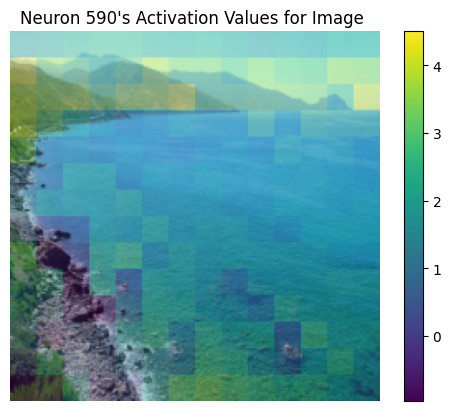

Class Name: promontory
Activation Value: 1.3092180490493774
Batch Index: 269



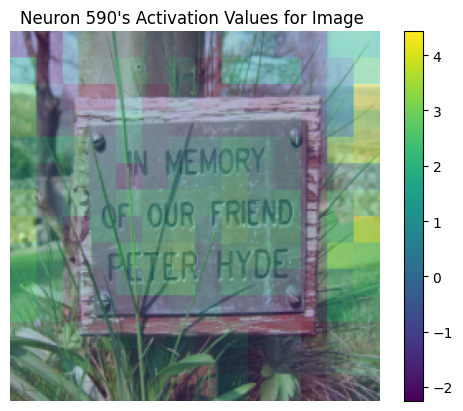

Class Name: brass
Activation Value: 1.2548496723175049
Batch Index: 62



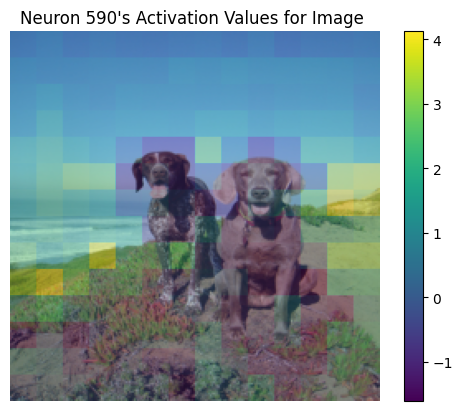

Class Name: German_short-haired_pointer
Activation Value: 1.0241700410842896
Batch Index: 321



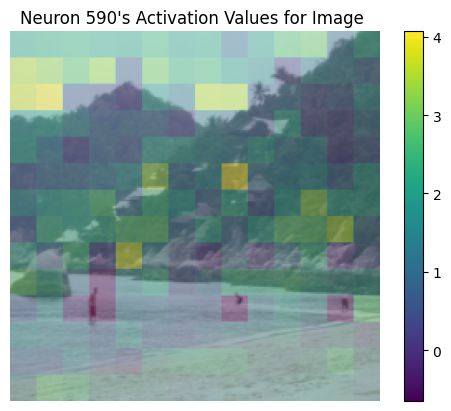

Class Name: sandbar
Activation Value: 0.9851382374763489
Batch Index: 386



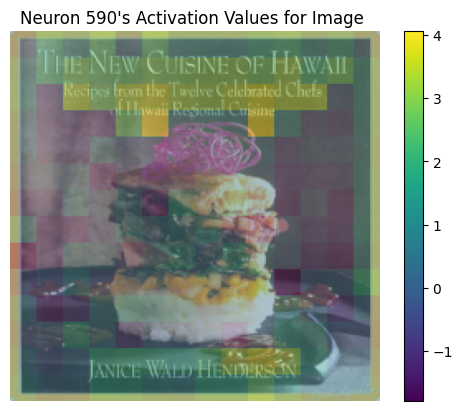

Class Name: book_jacket
Activation Value: 0.974570631980896
Batch Index: 160



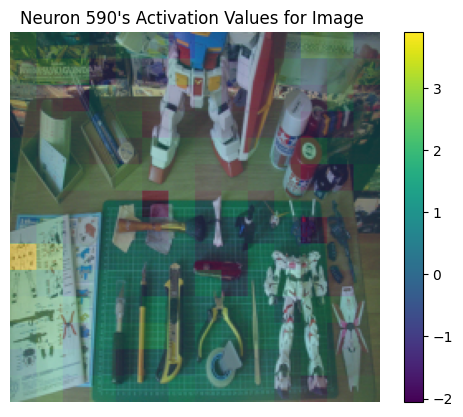

Class Name: carpenter's_kit
Activation Value: 0.8589165806770325
Batch Index: 256



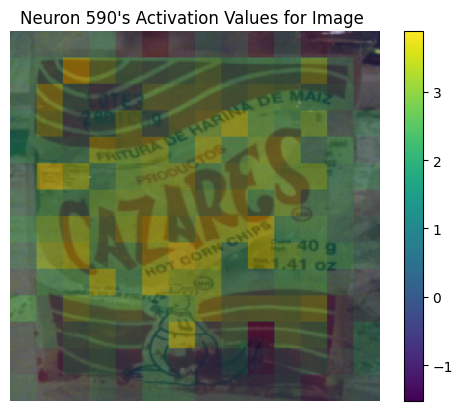

Class Name: packet
Activation Value: 0.8486865162849426
Batch Index: 428



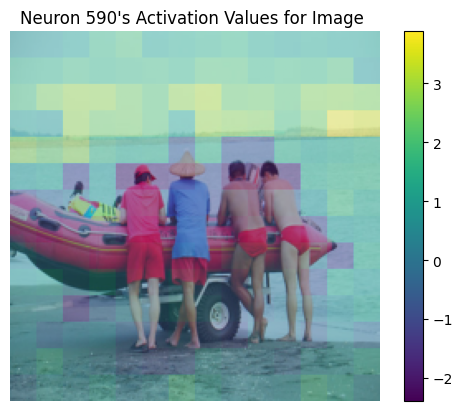

Class Name: swimming_trunks
Activation Value: 0.8464438915252686
Batch Index: 226



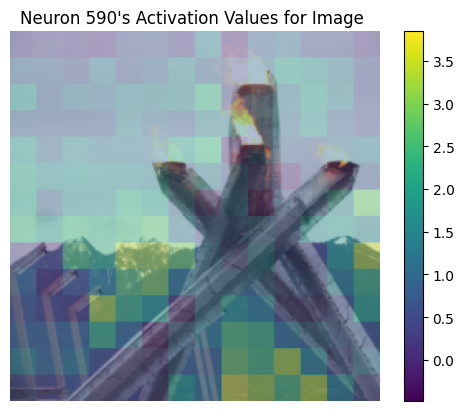

Class Name: torch
Activation Value: 0.8198298811912537
Batch Index: 127



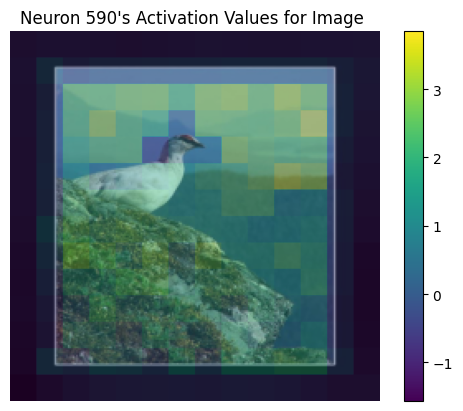

Class Name: ptarmigan
Activation Value: 0.8188760280609131
Batch Index: 437



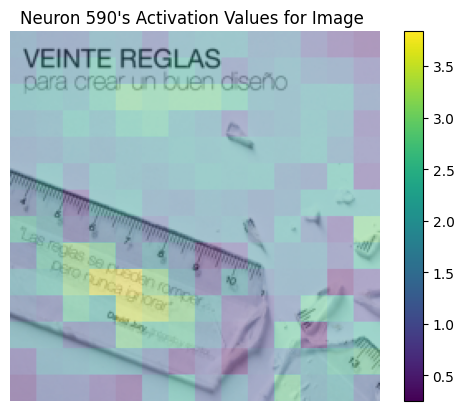

Class Name: rule
Activation Value: 0.8118782043457031
Batch Index: 34



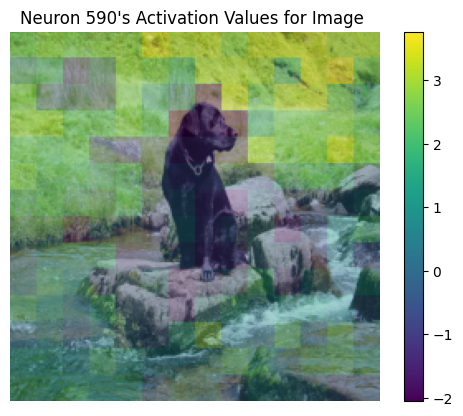

Class Name: Labrador_retriever
Activation Value: 0.7559043169021606
Batch Index: 100



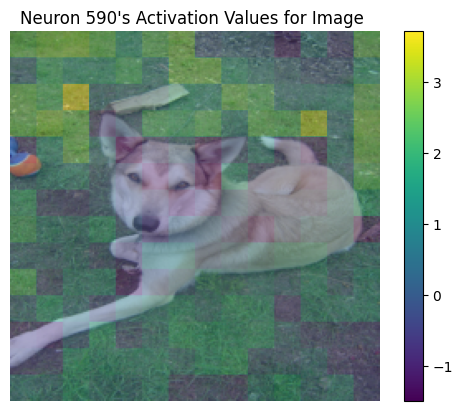

Class Name: Eskimo_dog
Activation Value: 0.7157484889030457
Batch Index: 3



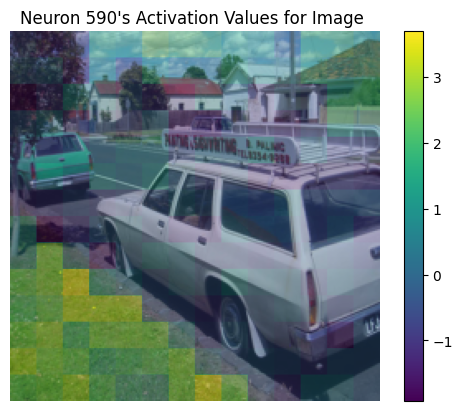

Class Name: beach_wagon
Activation Value: 0.7048681378364563
Batch Index: 145



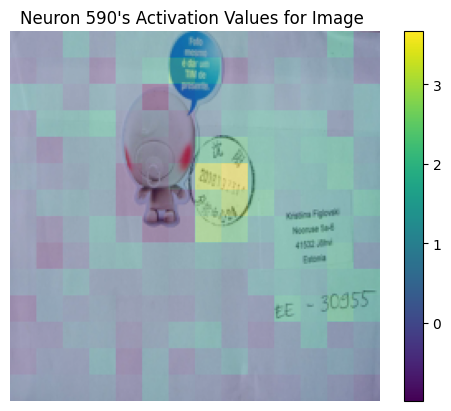

Class Name: envelope
Activation Value: 0.6871130466461182
Batch Index: 241



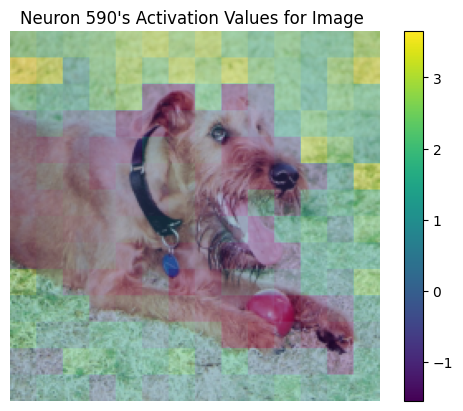

Class Name: Irish_terrier
Activation Value: 0.6727038025856018
Batch Index: 252



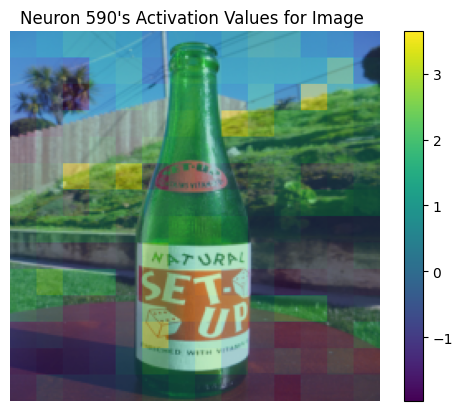

Class Name: pop_bottle
Activation Value: 0.6668406128883362
Batch Index: 224



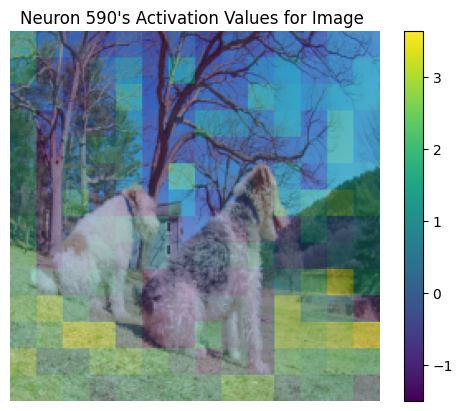

Class Name: wire-haired_fox_terrier
Activation Value: 0.6581368446350098
Batch Index: 1



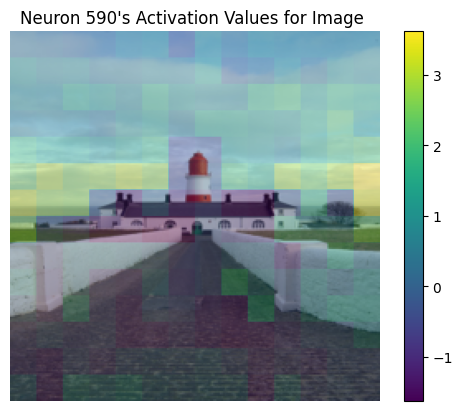

Class Name: beacon
Activation Value: 0.6509438157081604
Batch Index: 168



In [9]:
# Get top 10 class names, no duplicates
import matplotlib.pyplot as plt

specific_neuron_idx = 590

unique_top_entries = sorted_df[sorted_df['neuron_idx'] == specific_neuron_idx].drop_duplicates(subset='class_name').head(30)

# Extracting class names and activation values
unique_top_class_names = unique_top_entries['class_name'].tolist()
unique_top_activations = unique_top_entries['activation_value'].tolist()
unique_top_batch_idx = unique_top_entries['batch_idx'].tolist()

# Lists are ready to use
print("Top 10 Unique Class Names:", unique_top_class_names)
print("Corresponding Activations:", unique_top_activations)
print("Corresponding Batch Indices:", unique_top_batch_idx)


# Now plot

for i, batch_idx in enumerate(unique_top_batch_idx):
    image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, batch_idx)
    plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)
    print("Class Name:", unique_top_class_names[i])
    print("Activation Value:", unique_top_activations[i])
    print("Batch Index:", unique_top_batch_idx[i])
    print("")
# image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, unique_top_batch_idx[0])
# plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)

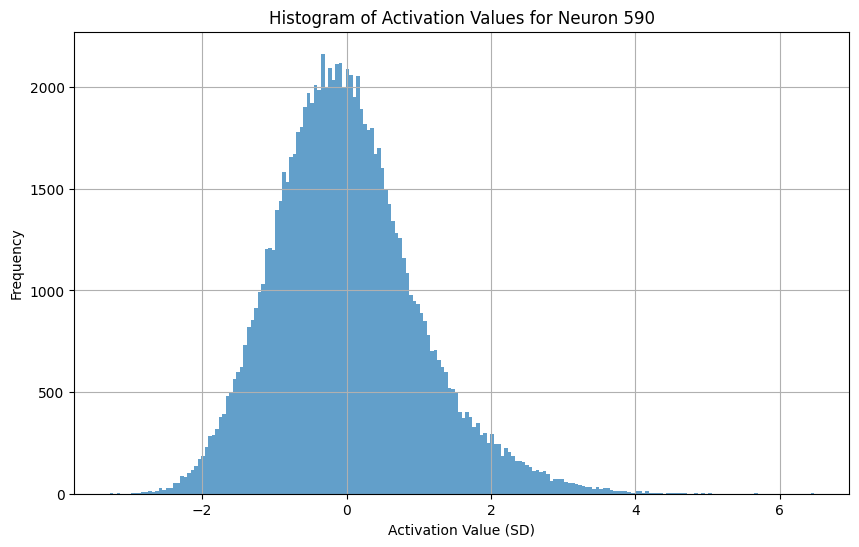

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Should this be in log scale?



# Filter the DataFrame to only include the neuron of interest
filtered_df = loaded[loaded['neuron_idx'] == specific_neuron_idx]

# Create a histogram of the activation values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['activation_value_sds'], bins=200, alpha=0.7)
plt.title(f'Histogram of Activation Values for Neuron {specific_neuron_idx}')
plt.xlabel('Activation Value (SD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Do this in log scale? 
